Authors: Morten Sund & Espen Norvang

https://boxofficeapp.herokuapp.com/index

## Mandatory exercise 2 DAT158 - Machine Learning.

In this exercise, we will build a machine learning model that predicts the box office income of a given movie.

### Table of Contents

* [1. Look at the Big Picture](#chapter1)
* [2. Get the Data](#chapter2)
* [3. Explore the Data](#chapter3)
* [4. Prepare the Data](#chapter4)
* [5. Explore different models and short-list the best ones](#chapter5)
* [6. Fine-Tuning the models](#chapter6)
* [7. Our Solution and Findings](#chapter7)
* [8. Launching and Monitoring the System](#chapter8)

# Setup
*Necessary imports and general setup*

In [68]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns
from pandas.plotting import scatter_matrix
import ast
from datetime import datetime
import joblib
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from numpy import nan
from collections import Counter
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV


In [69]:
# To make the notebook reproducible
seed = 42
np.random.seed(seed)

In [70]:
# To automatically reload modules defined in external files. Not necessary in this case, but often convenient.
%reload_ext autoreload
%autoreload 2

# To display plots directly in the notebook:
%matplotlib inline

# 1. Look at the Big Picture <a class="anchor" id="chapter1"></a>


This notebook is part of the submission for our second mandatory assignment on machine learning in the course DAT158 offered by the Western Norway University of Applied Sciences. The data set used is from the Kaggle TMDB Box Office Prediction competition. It contains metadata on over 7,000 past films from The Movie Database.

The focus of this assignment is to "play the whole game" in regards to machine learning. In that regard, we will not be spending too much time training the best model, but getting a working model to make predictions and then host it on a web application.

## Select a Performance Measure
The original competition on Kaggle uses Root Mean Squared Logarithmic Error (RMSE). However, we will be using the Root Mean Squared Error (RMSE) as our performance measure. This will give us an idea of how much error the system typically makes.

$$ RMSE = \sqrt{\frac{1}{n}\Sigma_{i=1}^{m}{\Big (h(x^{(i)})-y^{(i)}\Big)^2}} $$

# 2. Get the Data <a class="anchor" id="chapter2"></a>

The data can be retrieved from [TMDB Box Office Predition on Kaggle](https://www.kaggle.com/c/tmdb-box-office-prediction/data).
We have downloaded the data and stored it locally.

In [71]:
#lists the ficles in the folder
import os
print(os.listdir("data"))

['auto.csv', 'box_test.csv', 'box_train.csv', 'diabetes.csv', 'housing_data.csv', 'housing_test_data.csv', 'sample_submission.csv']


**The data is alreadty split into a training set and a test set. We import them as follows:**

We transform some of the columns from text to dict format in order for them to be easier to work with.

In [237]:
#Reads in the csv-files and creates a dataframe using pandas

train = pd.read_csv('data/box_train.csv')
test = pd.read_csv('data/box_test.csv')

# from this kernel: https://www.kaggle.com/gravix/gradient-in-a-box
dict_columns = ['belongs_to_collection', 'genres', 'production_companies',
                'production_countries', 'spoken_languages', 'Keywords', 'cast', 'crew']

def text_to_dict(df):
    for column in dict_columns:
        df[column] = df[column].apply(lambda x: {} if pd.isna(x) else ast.literal_eval(x) )
    return df
        
train = text_to_dict(train)
test = text_to_dict(test)

# 3. Explore the data <a class="anchor" id="chapter3"></a>

In [73]:
train.keys()

Index(['id', 'belongs_to_collection', 'budget', 'genres', 'homepage',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'runtime', 'spoken_languages',
       'status', 'tagline', 'title', 'Keywords', 'cast', 'crew', 'revenue'],
      dtype='object')

In [74]:
train.head()

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,...,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue
0,1,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",14000000,"[{'id': 35, 'name': 'Comedy'}]",NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,...,2/20/15,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651
1,2,"[{'id': 107674, 'name': 'The Princess Diaries ...",40000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,...,8/6/04,113.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It can take a lifetime to find true love; she'...,The Princess Diaries 2: Royal Engagement,"[{'id': 2505, 'name': 'coronation'}, {'id': 42...","[{'cast_id': 1, 'character': 'Mia Thermopolis'...","[{'credit_id': '52fe43fe9251416c7502563d', 'de...",95149435
2,3,{},3300000,"[{'id': 18, 'name': 'Drama'}]",http://sonyclassics.com/whiplash/,tt2582802,en,Whiplash,"Under the direction of a ruthless instructor, ...",64.299990,...,10/10/14,105.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The road to greatness can take you to the edge.,Whiplash,"[{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...","[{'cast_id': 5, 'character': 'Andrew Neimann',...","[{'credit_id': '54d5356ec3a3683ba0000039', 'de...",13092000
3,4,{},1200000,"[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...",http://kahaanithefilm.com/,tt1821480,hi,Kahaani,Vidya Bagchi (Vidya Balan) arrives in Kolkata ...,3.174936,...,3/9/12,122.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,NaN,Kahaani,"[{'id': 10092, 'name': 'mystery'}, {'id': 1054...","[{'cast_id': 1, 'character': 'Vidya Bagchi', '...","[{'credit_id': '52fe48779251416c9108d6eb', 'de...",16000000
4,5,{},0,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",NaN,tt1380152,ko,마린보이,Marine Boy is the story of a former national s...,1.148070,...,2/5/09,118.0,"[{'iso_639_1': 'ko', 'name': '한국어/조선말'}]",Released,NaN,Marine Boy,{},"[{'cast_id': 3, 'character': 'Chun-soo', 'cred...","[{'credit_id': '52fe464b9251416c75073b43', 'de...",3923970


In [75]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     3000 non-null   int64  
 1   belongs_to_collection  3000 non-null   object 
 2   budget                 3000 non-null   int64  
 3   genres                 3000 non-null   object 
 4   homepage               946 non-null    object 
 5   imdb_id                3000 non-null   object 
 6   original_language      3000 non-null   object 
 7   original_title         3000 non-null   object 
 8   overview               2992 non-null   object 
 9   popularity             3000 non-null   float64
 10  poster_path            2999 non-null   object 
 11  production_companies   3000 non-null   object 
 12  production_countries   3000 non-null   object 
 13  release_date           3000 non-null   object 
 14  runtime                2998 non-null   float64
 15  spok

In [76]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4398 entries, 0 to 4397
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4398 non-null   int64  
 1   belongs_to_collection  4398 non-null   object 
 2   budget                 4398 non-null   int64  
 3   genres                 4398 non-null   object 
 4   homepage               1420 non-null   object 
 5   imdb_id                4398 non-null   object 
 6   original_language      4398 non-null   object 
 7   original_title         4398 non-null   object 
 8   overview               4384 non-null   object 
 9   popularity             4398 non-null   float64
 10  poster_path            4397 non-null   object 
 11  production_companies   4398 non-null   object 
 12  production_countries   4398 non-null   object 
 13  release_date           4397 non-null   object 
 14  runtime                4394 non-null   float64
 15  spok

We see that there are several columns that contain null values. We will need to handle these later.

In [77]:
train.describe()

,id,budget,popularity,runtime,revenue
count,3000.000000,3.000000e+03,3000.000000,2998.000000,3.000000e+03
mean,1500.500000,2.253133e+07,8.463274,107.856571,6.672585e+07
std,866.169729,3.702609e+07,12.104000,22.086434,1.375323e+08
min,1.000000,0.000000e+00,0.000001,0.000000,1.000000e+00
25%,750.750000,0.000000e+00,4.018053,94.000000,2.379808e+06
50%,1500.500000,8.000000e+06,7.374861,104.000000,1.680707e+07
75%,2250.250000,2.900000e+07,10.890983,118.000000,6.891920e+07
max,3000.000000,3.800000e+08,294.337037,338.000000,1.519558e+09


**We want to visualize the data to gain insights.**
We use a copy of the training set so we can play with it without harming it.

From inspection of the data contents we can see that it contains some data contained in objects that does not work well with some plotting methods.

In [78]:
box_office = train.copy()

[]

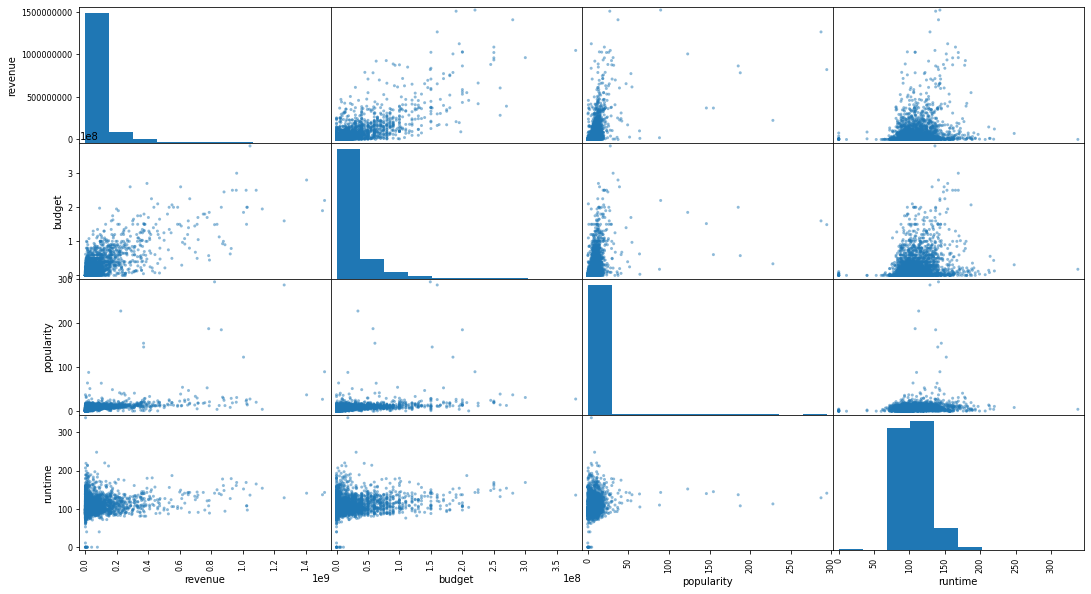

In [79]:
attributes = ["revenue", "budget", "popularity", "runtime"]
scatter_matrix(box_office[attributes], figsize=(18, 10))
plt.plot()

It seems like there is a correlation between budget and revenue.

In [80]:
corr_matrix = box_office.corr()
corr_matrix["revenue"].sort_values(ascending=False)

revenue       1.000000
budget        0.752965
popularity    0.461460
runtime       0.216380
id            0.000610
Name: revenue, dtype: float64

We can tell from the correlation-function that there is indeed a correlation between budget and revenue.

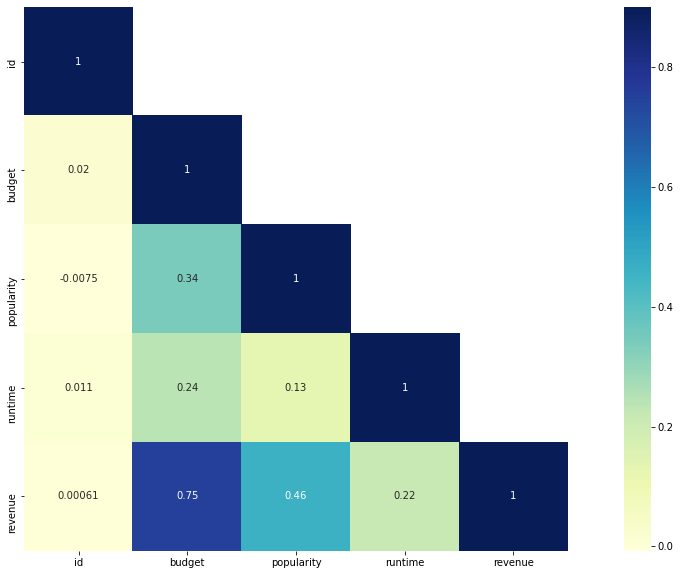

In [81]:
mask = np.array(corr_matrix)
mask[np.tril_indices_from(mask)] = False
fig,ax= plt.subplots()
fig.set_size_inches(20,10)
sns.heatmap(corr_matrix, mask=mask,vmax=.9, square=True,annot=True, cmap="YlGnBu")

The heatmap visualizes the correlation.

**Belongs to collection**

In [82]:
box_office['belongs_to_collection'].head()

0    [{'id': 313576, 'name': 'Hot Tub Time Machine ...
1    [{'id': 107674, 'name': 'The Princess Diaries ...
2                                                   {}
3                                                   {}
4                                                   {}
Name: belongs_to_collection, dtype: object

The 'belongs_to_collection' is a bit messy to work with. We wanna see if a movie belongs to a collection or not.

These neat lambda expressions are borrowed from this notebook: https://www.kaggle.com/artgor/eda-feature-engineering-and-model-interpretation

In [83]:
box_office['belongs_to_collection'].apply(lambda x: len(x) if x != {} else 0).value_counts()

0    2396
1     604
Name: belongs_to_collection, dtype: int64

In [84]:
box_office['collection_name'] = box_office['belongs_to_collection'].apply(lambda x: x[0]['name'] if x != {} else 0)
box_office['has_collection'] = box_office['belongs_to_collection'].apply(lambda x: len(x) if x != {} else 0)

In [85]:
box_office['has_collection']

0       1
1       1
2       0
3       0
4       0
       ..
2995    0
2996    0
2997    0
2998    0
2999    0
Name: has_collection, Length: 3000, dtype: int64

In [86]:
box_office['collection_name']

0       Hot Tub Time Machine Collection
1       The Princess Diaries Collection
2                                     0
3                                     0
4                                     0
                     ...               
2995                                  0
2996                                  0
2997                                  0
2998                                  0
2999                                  0
Name: collection_name, Length: 3000, dtype: object

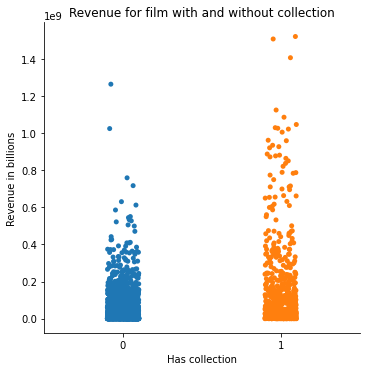

In [87]:
catplot = sns.catplot(x='has_collection', y='revenue', data=box_office);
plt.title('Revenue for film with and without collection');
(catplot.set_axis_labels("Has collection", "Revenue in billions"))

From the catplot we assume that movies being part of a collection generally generated more revenue.

**Homepage**

In [88]:
box_office['homepage'].head()

0                                  NaN
1                                  NaN
2    http://sonyclassics.com/whiplash/
3           http://kahaanithefilm.com/
4                                  NaN
Name: homepage, dtype: object

In [89]:
box_office['has_homepage'] = box_office['homepage'].apply(lambda x: 0 if pd.isna(x) else 1)

In [90]:
box_office['has_homepage'].head()

0    0
1    0
2    1
3    1
4    0
Name: has_homepage, dtype: int64

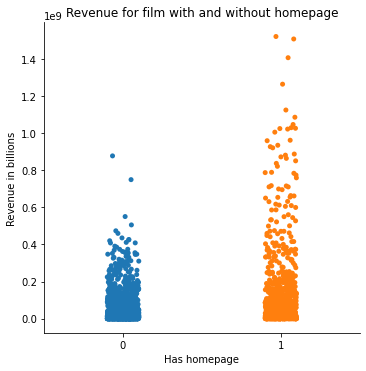

In [91]:
catplot = sns.catplot(x='has_homepage', y='revenue', data=box_office);
plt.title('Revenue for film with and without homepage');
(catplot.set_axis_labels("Has homepage", "Revenue in billions"))

It seems like movies that have a homepage generated more revenue.

**Genres**

In [92]:
box_office['genres'].head(10)

0                       [{'id': 35, 'name': 'Comedy'}]
1    [{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...
2                        [{'id': 18, 'name': 'Drama'}]
3    [{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...
4    [{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...
5    [{'id': 16, 'name': 'Animation'}, {'id': 12, '...
6    [{'id': 27, 'name': 'Horror'}, {'id': 53, 'nam...
7                  [{'id': 99, 'name': 'Documentary'}]
8    [{'id': 28, 'name': 'Action'}, {'id': 35, 'nam...
9    [{'id': 35, 'name': 'Comedy'}, {'id': 10402, '...
Name: genres, dtype: object

Genres are also a bunch of dicts. We will look at how many genres a movie can be said to have.

In [93]:
print('Number of genres in films')
box_office['genres'].apply(lambda x: len(x) if x != {} else 0).value_counts()

Number of genres in films


2    972
3    900
1    593
4    393
5    111
6     21
0      7
7      3
Name: genres, dtype: int64

First off, we see that most movies have 2-3 genres. Some have 0 genres, which we will assume are outliers.

In [94]:
box_office['list_of_genres'] = list(box_office['genres'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)

In [95]:
box_office['list_of_genres'].head()

0                            [Comedy]
1    [Comedy, Drama, Family, Romance]
2                             [Drama]
3                   [Thriller, Drama]
4                  [Action, Thriller]
Name: list_of_genres, dtype: object

In [96]:
Counter(i for j in box_office['list_of_genres'] for i in j).most_common()

[('Drama', 1531),
 ('Comedy', 1028),
 ('Thriller', 789),
 ('Action', 741),
 ('Romance', 571),
 ('Crime', 469),
 ('Adventure', 439),
 ('Horror', 301),
 ('Science Fiction', 290),
 ('Family', 260),
 ('Fantasy', 232),
 ('Mystery', 225),
 ('Animation', 141),
 ('History', 132),
 ('Music', 100),
 ('War', 100),
 ('Documentary', 87),
 ('Western', 43),
 ('Foreign', 31),
 ('TV Movie', 1)]

In [97]:
box_office['no_of_genres'] = box_office['list_of_genres'].apply(lambda x: len(x) if x != {} else 0)

In [98]:
box_office['no_of_genres']

0       1
1       4
2       1
3       2
4       2
       ..
2995    2
2996    2
2997    4
2998    2
2999    3
Name: no_of_genres, Length: 3000, dtype: int64

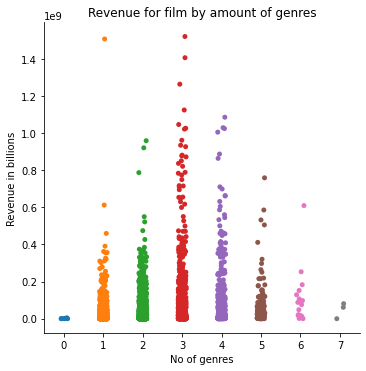

In [99]:
catplot = sns.catplot(x='no_of_genres', y='revenue', data=box_office);
plt.title('Revenue for film by amount of genres');
(catplot.set_axis_labels("No of genres", "Revenue in billions"))

We see that movies that are in three genres generates most revenue.

**Original language**

Taking a look at what languages the movies are originally made in.

In [100]:
box_office['original_language'].head(10)

0    en
1    en
2    en
3    hi
4    ko
5    en
6    en
7    en
8    en
9    en
Name: original_language, dtype: object

In [101]:
box_office['original_language'].value_counts()

en    2575
fr      78
ru      47
es      43
hi      42
ja      37
it      24
cn      20
ko      20
zh      19
de      18
ta      16
sv       8
pt       6
nl       6
fa       5
da       5
ro       4
hu       3
tr       3
ml       2
fi       2
te       2
no       2
pl       2
el       1
ur       1
nb       1
id       1
vi       1
mr       1
ar       1
he       1
sr       1
bn       1
cs       1
Name: original_language, dtype: int64

Most of the movies have english as their original language. We take a look at whether or not having english as the original language matters.

In [102]:
box_office['original_language_is_english'] = box_office['original_language'].apply(lambda x: 1 if x == 'en' else 0)

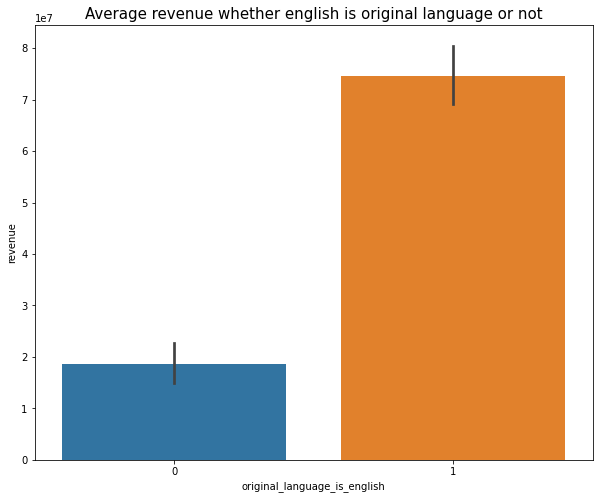

In [103]:
plt.figure(figsize=(10,8))
sns.barplot(x='original_language_is_english', y='revenue', data=box_office)
plt.title("Average revenue whether english is original language or not",fontsize=15)
plt.show()

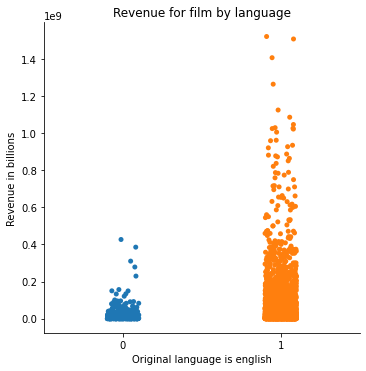

In [104]:
catplot = sns.catplot(x='original_language_is_english', y='revenue', data=box_office);
plt.title('Revenue for film by language');
(catplot.set_axis_labels("Original language is english", "Revenue in billions"))

English-spoken movies seems to have more revenue.

**Production company**

In [105]:
box_office['production_companies'].head()

0    [{'name': 'Paramount Pictures', 'id': 4}, {'na...
1          [{'name': 'Walt Disney Pictures', 'id': 2}]
2    [{'name': 'Bold Films', 'id': 2266}, {'name': ...
3                                                   {}
4                                                   {}
Name: production_companies, dtype: object

In [106]:
box_office['list_of_production_companies'] = list(box_office['production_companies'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)

In [107]:
box_office['list_of_production_companies']

0       [Paramount Pictures, United Artists, Metro-Gol...
1                                  [Walt Disney Pictures]
2       [Bold Films, Blumhouse Productions, Right of W...
3                                                      []
4                                                      []
                              ...                        
2995             [Warner Bros., Morgan Creek Productions]
2996                           [Memfis Film, Film i Väst]
2997    [New Line Cinema, Forge, The Steve Tisch Company]
2998                   [Jersey Films, Loofah Productions]
2999    [Lions Gate Films, Vertigo Entertainment, Goth...
Name: list_of_production_companies, Length: 3000, dtype: object

Many movies have multiple production companies. We will make a new feature which tells us exactly how many production companies were used in a movie.

In [108]:
box_office['no_of_production_companies'] = box_office['list_of_production_companies'].apply(lambda x: len(x) if x != {} else 0)

In [109]:
box_office['no_of_production_companies']

0       3
1       1
2       3
3       0
4       0
       ..
2995    2
2996    2
2997    3
2998    2
2999    6
Name: no_of_production_companies, Length: 3000, dtype: int64

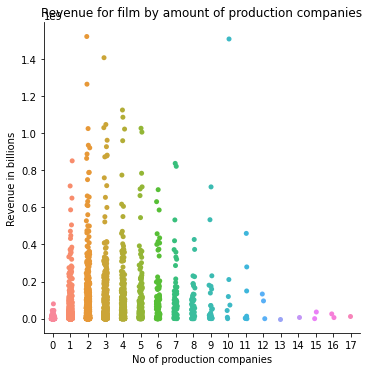

In [110]:
catplot = sns.catplot(x='no_of_production_companies', y='revenue', data=box_office);
plt.title('Revenue for film by amount of production companies');
(catplot.set_axis_labels("No of production companies", "Revenue in billions"))

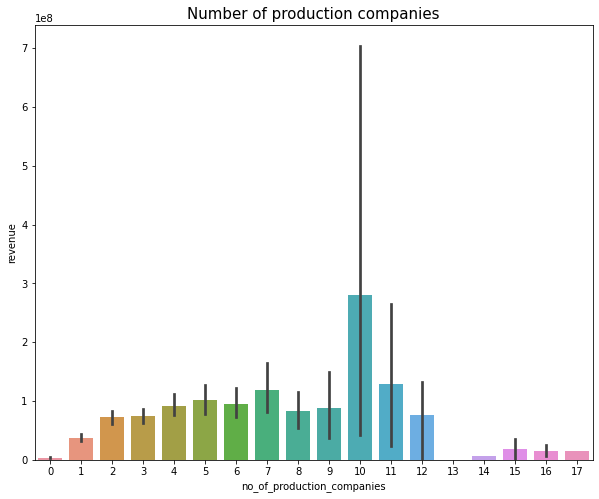

In [111]:
plt.figure(figsize=(10,8))
sns.barplot(x='no_of_production_companies', y='revenue', data=box_office)
plt.title("Number of production companies",fontsize=15)
plt.show()

Quite interesting results.

In [112]:
from collections import Counter

In [113]:
N = 50
print('Top N production companies based on movie count:')
top_N_production_companies = Counter([i for j in box_office['list_of_production_companies'] for i in j]).most_common(N)
print(top_N_production_companies)

Top N production companies based on movie count:
[('Warner Bros.', 202), ('Universal Pictures', 188), ('Paramount Pictures', 161), ('Twentieth Century Fox Film Corporation', 138), ('Columbia Pictures', 91), ('Metro-Goldwyn-Mayer (MGM)', 84), ('New Line Cinema', 75), ('Touchstone Pictures', 63), ('Walt Disney Pictures', 62), ('Columbia Pictures Corporation', 61), ('TriStar Pictures', 53), ('Relativity Media', 48), ('Canal+', 46), ('United Artists', 44), ('Miramax Films', 40), ('Village Roadshow Pictures', 36), ('Regency Enterprises', 31), ('BBC Films', 30), ('Dune Entertainment', 30), ('Working Title Films', 30), ('Fox Searchlight Pictures', 29), ('StudioCanal', 28), ('Lionsgate', 28), ('DreamWorks SKG', 27), ('Fox 2000 Pictures', 25), ('Summit Entertainment', 24), ('Hollywood Pictures', 24), ('Orion Pictures', 24), ('Amblin Entertainment', 23), ('Dimension Films', 23), ('Castle Rock Entertainment', 21), ('Epsilon Motion Pictures', 21), ('Morgan Creek Productions', 21), ('Original Film'

In [114]:
top_N_production_companies_name = []
for company in top_N_production_companies:
    top_N_production_companies_name.append(company[0])
print(top_N_production_companies_name)

['Warner Bros.', 'Universal Pictures', 'Paramount Pictures', 'Twentieth Century Fox Film Corporation', 'Columbia Pictures', 'Metro-Goldwyn-Mayer (MGM)', 'New Line Cinema', 'Touchstone Pictures', 'Walt Disney Pictures', 'Columbia Pictures Corporation', 'TriStar Pictures', 'Relativity Media', 'Canal+', 'United Artists', 'Miramax Films', 'Village Roadshow Pictures', 'Regency Enterprises', 'BBC Films', 'Dune Entertainment', 'Working Title Films', 'Fox Searchlight Pictures', 'StudioCanal', 'Lionsgate', 'DreamWorks SKG', 'Fox 2000 Pictures', 'Summit Entertainment', 'Hollywood Pictures', 'Orion Pictures', 'Amblin Entertainment', 'Dimension Films', 'Castle Rock Entertainment', 'Epsilon Motion Pictures', 'Morgan Creek Productions', 'Original Film', 'Focus Features', 'Legendary Pictures', 'Participant Media', 'Blumhouse Productions', 'New Regency Pictures', 'Film4', 'Spyglass Entertainment', 'Imagine Entertainment', 'Screen Gems', 'Millennium Films', 'TSG Entertainment', 'Lakeshore Entertainment

In [115]:
for company in top_N_production_companies_name:
    box_office['produced_by_top_company'] = box_office['list_of_production_companies'].apply(lambda x: 1 if company in x else 0)

box_office


,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,...,revenue,collection_name,has_collection,has_homepage,list_of_genres,no_of_genres,original_language_is_english,list_of_production_companies,no_of_production_companies,produced_by_top_company
0,1,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",14000000,"[{'id': 35, 'name': 'Comedy'}]",NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,...,12314651,Hot Tub Time Machine Collection,1,0,[Comedy],1,1,"[Paramount Pictures, United Artists, Metro-Gol...",3,0
1,2,"[{'id': 107674, 'name': 'The Princess Diaries ...",40000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,...,95149435,The Princess Diaries Collection,1,0,"[Comedy, Drama, Family, Romance]",4,1,[Walt Disney Pictures],1,0
2,3,{},3300000,"[{'id': 18, 'name': 'Drama'}]",http://sonyclassics.com/whiplash/,tt2582802,en,Whiplash,"Under the direction of a ruthless instructor, ...",64.299990,...,13092000,0,0,1,[Drama],1,1,"[Bold Films, Blumhouse Productions, Right of W...",3,0
3,4,{},1200000,"[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...",http://kahaanithefilm.com/,tt1821480,hi,Kahaani,Vidya Bagchi (Vidya Balan) arrives in Kolkata ...,3.174936,...,16000000,0,0,1,"[Thriller, Drama]",2,0,[],0,0
4,5,{},0,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",NaN,tt1380152,ko,마린보이,Marine Boy is the story of a former national s...,1.148070,...,3923970,0,0,0,"[Action, Thriller]",2,0,[],0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,2996,{},0,"[{'id': 35, 'name': 'Comedy'}, {'id': 10749, '...",NaN,tt0109403,en,Chasers,Military men Rock Reilly and Eddie Devane are ...,9.853270,...,1596687,0,0,0,"[Comedy, Romance]",2,1,"[Warner Bros., Morgan Creek Productions]",2,0
2996,2997,{},0,"[{'id': 18, 'name': 'Drama'}, {'id': 10402, 'n...",NaN,tt2364975,sv,Vi är bäst!,Three girls in 1980s Stockholm decide to form ...,3.727996,...,180590,0,0,0,"[Drama, Music]",2,0,"[Memfis Film, Film i Väst]",2,0
2997,2998,{},65000000,"[{'id': 80, 'name': 'Crime'}, {'id': 28, 'name...",NaN,tt0116908,en,The Long Kiss Goodnight,"Samantha Caine, suburban homemaker, is the ide...",14.482345,...,89456761,0,0,0,"[Crime, Action, Mystery, Thriller]",4,1,"[New Line Cinema, Forge, The Steve Tisch Company]",3,0
2998,2999,{},42000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 10749, '...",http://www.alongcamepolly.com/,tt0343135,en,Along Came Polly,Reuben Feffer is a guy who's spent his entire ...,15.725542,...,171963386,0,0,1,"[Comedy, Romance]",2,1,"[Jersey Films, Loofah Productions]",2,0


In [116]:
box_office.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 32 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id                            3000 non-null   int64  
 1   belongs_to_collection         3000 non-null   object 
 2   budget                        3000 non-null   int64  
 3   genres                        3000 non-null   object 
 4   homepage                      946 non-null    object 
 5   imdb_id                       3000 non-null   object 
 6   original_language             3000 non-null   object 
 7   original_title                3000 non-null   object 
 8   overview                      2992 non-null   object 
 9   popularity                    3000 non-null   float64
 10  poster_path                   2999 non-null   object 
 11  production_companies          3000 non-null   object 
 12  production_countries          3000 non-null   object 
 13  rel

In [117]:
box_office = box_office.select_dtypes(exclude=['object'])

In [118]:
box_office.drop(['id', 'produced_by_top_company'], axis=1)

,budget,popularity,runtime,revenue,has_collection,has_homepage,no_of_genres,original_language_is_english,no_of_production_companies
0,14000000,6.575393,93.0,12314651,1,0,1,1,3
1,40000000,8.248895,113.0,95149435,1,0,4,1,1
2,3300000,64.299990,105.0,13092000,0,1,1,1,3
3,1200000,3.174936,122.0,16000000,0,1,2,0,0
4,0,1.148070,118.0,3923970,0,0,2,0,0
...,...,...,...,...,...,...,...,...,...
2995,0,9.853270,102.0,1596687,0,0,2,1,2
2996,0,3.727996,102.0,180590,0,0,2,0,2
2997,65000000,14.482345,120.0,89456761,0,0,4,1,3
2998,42000000,15.725542,90.0,171963386,0,1,2,1,2


In [119]:
box_office['budget'].mean()

22531334.11

# 4. Prepare the Data for Machine Learning Algorithms <a class="anchor" id="chapter4"></a>
We revert to a clean training set:

In [238]:
box_office = train.drop(['revenue', 'id'], axis=1)

In [239]:
box_office_labels = train['revenue'].copy()

In [240]:
box_office.runtime.apply(lambda x: 1 if x == 0 else 0).value_counts()

0    2988
1      12
Name: runtime, dtype: int64

12 movies have a runtime of 0. We assume that this is a mistake, and replace them with nan so they can be imputed in the pipeline.



## Pipeline
We want to construct a decent pipeline for our data to go through. This will also be important for new data that is coming in.

### Combining Attributes
We add some extra features

In [124]:
###
#budget_ix, popularity_ix, runtime_ix = 0, 1, 2
#
#class AttributesAdder(BaseEstimator, TransformerMixin):
#    def __init__(self, add_new_attributes=True): # no *args or **kargs
#        self.add_new_attributes = add_new_attributes
#    def fit(self, X, y=None):
#        return self
#    def transform(self, X):
#        budget_to_popularity = X[:, budget_ix] / X[:, popularity_ix]
#        budget_to_runtime = X[:, budget_ix] / X[:, runtime_ix]
#        return np.c_[X, budget_to_popularity, budget_to_runtime] 
###

#### Remove and Fix Data
We define a class to handle transformation of our columns.

In [245]:
def fix_data(df):
    df['has_collection'] = df['belongs_to_collection'].apply(lambda x: len(x) if x != {} else 0)
    df['has_homepage'] = df['homepage'].apply(lambda x: 0 if pd.isna(x) else 1)
    df['list_of_genres'] = list(df['genres'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)
    df['no_of_genres'] = df['list_of_genres'].apply(lambda x: len(x) if x != {} else 0)
    df['original_language_is_english'] = df['original_language'].apply(lambda x: 1 if x == 'en' else 0)
    df['list_of_production_companies'] = list(df['production_companies'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)
    df['no_of_production_companies'] = df['list_of_production_companies'].apply(lambda x: len(x) if x != {} else 0)
    df['runtime'] = df['runtime'].replace(0, nan)
    df = df.select_dtypes(exclude=['object'])
    return df

In [246]:
from pyprocess import AttributesAdder
num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs', AttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

In [247]:
freq_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="most_frequent"))
])

In [248]:
box_office_fixed = fix_data(box_office)
box_office_num = box_office_fixed[["budget", "popularity", "runtime"]]
num_attribs = list(box_office_num)
box_office_frequents = box_office_fixed[["has_collection", "has_homepage", "original_language_is_english", "no_of_genres", "no_of_production_companies"]]
freq_attribs = list(box_office_frequents)


full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("freq", freq_pipeline, freq_attribs)
        ], remainder='passthrough')

box_office_prepared = full_pipeline.fit_transform(box_office_fixed)

In [249]:
box_office_labels.head()

0    12314651
1    95149435
2    13092000
3    16000000
4     3923970
Name: revenue, dtype: int64

In [250]:
#Saving the pipeline
joblib.dump(full_pipeline, "box_office_pipeline.joblib")

['box_office_pipeline.joblib']

In [251]:
box_office_prepared[:2]


array([[-0.23045256, -0.15599768, -0.72739931, -0.09089351, -0.15792215,
         1.        ,  0.        ,  1.        ,  1.        ,  3.        ],
       [ 0.47187212, -0.01771439,  0.22531753,  0.15537861,  0.49523681,
         1.        ,  0.        ,  1.        ,  4.        ,  1.        ]])

# 5. Explore different models and short-list the best ones <a class="anchor" id="chapter5"></a>
We are going to look at different models and find out which are best suited for determining the median house value.

## Linear Regression

We start by training a Linear Regression model:

In [134]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(box_office_prepared, box_office_labels)

LinearRegression()

In [135]:
from sklearn.metrics import mean_squared_error
box_office_predictions = lin_reg.predict(box_office_prepared)
lin_mse = mean_squared_error(box_office_labels, box_office_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

80852831.95958993

A typical prediction error of around \$80 million is not ideal

## Cross-Validation
We use K-fold cross-validation to check the how the Decision Tree performs. This will split the training set into 10 distinct subsets called folds, then train and evaluate the model 10 times, picking a different fold for evaluation every time and training on the other 9 folds. The result is an array containing the 10 eval scores:

In [136]:
from sklearn.model_selection import cross_val_score

We define a function to help us get a better look at the results:

In [137]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

In [138]:
lin_scores = cross_val_score(lin_reg, box_office_prepared, box_office_labels,
                              scoring="neg_mean_squared_error", cv=10)

lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [82303942.90179817 84188193.88001259 91885559.1175867  76890400.22319855
 79653599.03399785 94820597.66058679 68812432.48032902 78700668.42128879
 85800518.9471443  76341222.19222757]
Mean: 81939713.48581704
Standard deviation: 7278825.979633993


The result is still quite bad after validating

## Random Forest
Next up is a random forest regressor. This is a type of Ensemble Learning, where we build a model on top of many other models. The Random Forest trains many Decision Trees on random subsets of the features, then averaging out their predictions.

In [139]:
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor()
forest_reg.fit(box_office_prepared, box_office_labels)

predictions = forest_reg.predict(box_office_prepared)
forest_mse = mean_squared_error(box_office_labels, predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

29489456.644674208

The RMSE from the random forest looks more promising!

In [148]:
forest_scores = cross_val_score(forest_reg, box_office_prepared, box_office_labels, scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [69949870.71636793 70371167.86249933 94441675.55080155 72276365.82360768
 82364249.65887925 91070743.34023458 64449035.42615367 83285905.59949748
 80713452.26955304 68597922.47182931]
Mean: 77752038.87194239
Standard deviation: 9605726.56108165


We see that the score on the training set is much better than on the validation sets. We conclude that the model is still overfitting the training set quite badly.

### XGBoost
XGBoost is a gradient boosting implementation.

In [149]:
xgb_model = xgb.XGBRegressor(n_jobs=-1, random_state=seed)
xgb_model.fit(box_office_prepared, box_office_labels)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=-1, num_parallel_tree=1, random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [150]:
box_office_pred = xgb_model.predict(box_office_prepared)

In [151]:
mse=mean_squared_error(box_office_labels, box_office_pred)
print(np.sqrt(mse))

15608575.32618037


RMSE of \$15,608,575 definitely looks more promising

In [152]:
%%time
xgb_scores = cross_val_score(xgb_model, box_office_prepared, box_office_labels, scoring="neg_mean_squared_error", cv=10)
xgb_rmse_scores = np.sqrt(-xgb_scores)
display_scores(xgb_rmse_scores)

Scores: [70817504.73649594 75967717.13139224 95666066.96009938 66734242.80039774
 82145402.43040739 99638685.90370269 76839165.32963371 90749643.34477803
 84459026.73672532 74366382.41135783]
Mean: 81738383.77849904
Standard deviation: 10291796.349035827
Wall time: 2.78 s


Dissappointing, cross validation indicates that XGBoost performs worse than our random forest. We will have to look at tuning it further to make a final decision.

# 6. Fine-Tuning the models <a class="anchor" id="chapter6">
We are going to start fine tuning our a couple of our models and see if we can find the best hyperparameters for them.

**Random Forest**

In [153]:
%%time

param_grid = [
    {'n_estimators': [3, 30, 150, 300 ], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [5, 10], 'max_features': [2, 3, 4]},
  ]

forest_reg = RandomForestRegressor(random_state=seed)

grid_search = GridSearchCV(forest_reg, param_grid, cv=10,
                           scoring='neg_mean_squared_error',
                           return_train_score=True,
                           refit=True,
                           n_jobs=-1) #all processors
grid_search.fit(box_office_prepared, box_office_labels)


Wall time: 42.5 s


GridSearchCV(cv=10, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 30, 150, 300]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [5, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [154]:
grid_search.best_params_

{'max_features': 2, 'n_estimators': 300}

In [155]:
grid_search.best_estimator_

RandomForestRegressor(max_features=2, n_estimators=300, random_state=42)

In [156]:
forest_reg = grid_search.best_estimator_
forest_reg.fit(box_office_prepared, box_office_labels)

predictions = forest_reg.predict(box_office_prepared)

In [157]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
     print(np.sqrt(-mean_score), params)

92905096.32329017 {'max_features': 2, 'n_estimators': 3}
77405919.15269485 {'max_features': 2, 'n_estimators': 30}
76129634.45321076 {'max_features': 2, 'n_estimators': 150}
75953963.93504147 {'max_features': 2, 'n_estimators': 300}
93324574.27113537 {'max_features': 4, 'n_estimators': 3}
78321571.19110079 {'max_features': 4, 'n_estimators': 30}
76896483.52953103 {'max_features': 4, 'n_estimators': 150}
76752601.98892114 {'max_features': 4, 'n_estimators': 300}
91454025.12821834 {'max_features': 6, 'n_estimators': 3}
78828624.06367493 {'max_features': 6, 'n_estimators': 30}
77183633.41733287 {'max_features': 6, 'n_estimators': 150}
77192153.99647759 {'max_features': 6, 'n_estimators': 300}
90830903.63322744 {'max_features': 8, 'n_estimators': 3}
78962598.99175255 {'max_features': 8, 'n_estimators': 30}
77980183.87964107 {'max_features': 8, 'n_estimators': 150}
77961687.06820634 {'max_features': 8, 'n_estimators': 300}
84405226.5881219 {'bootstrap': False, 'max_features': 2, 'n_estimato

Using max_features=2 and n_estimators=300 we are looking at an RMSE of about 75959963 . This is a slight improvement.

In [158]:
forest_reg.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 2,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 300,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [159]:
joblib.dump(forest_reg, "forest_reg_2feat_300est_new.joblib", compress=8)

['forest_reg_2feat_300est_new.joblib']

### Tuning XGBoost
The XGBoost model looked promising. We tune it. We use a large parameter grid that often works okay-ish:

In [160]:
xgb_param_grid_large = {
        'learning_rate': [0.1, 0.05, 0.2],
        'n_estimators': [50, 100, 500, 600],
        'min_child_weight': [1, 5, 10],
        'gamma': [0.0, 1.0, 1.5],
        'subsample': [0.6, 1.0],
        'colsample_bytree': [0.5, 0.6, 0.8],
        'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
        }

A complete grid search over all of these combinations only works if you either have a small data set or a lot of time available.

A random search, where you simply try a set number of different combinations at random, can sometimes produce improved models, depending on how many iterations you have time for.

Let's try it out:

In [161]:
xgb_reg = XGBRegressor(n_jobs=-1, random_state=42)

In [162]:
r_xgb_reg = RandomizedSearchCV(xgb_reg, xgb_param_grid_large, n_iter=100, verbose=1, n_jobs=-1, cv=10, random_state=42)

In [163]:
%%time
r_xgb_reg.fit(box_office_prepared, box_office_labels)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   27.6s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  2.9min finished


Wall time: 2min 51s


RandomizedSearchCV(cv=10,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, gamma=None,
                                          gpu_id=None, importance_type='gain',
                                          interaction_constraints=None,
                                          learning_rate=None,
                                          max_delta_step=None, max_depth=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          n_estimators=100,...
                                          scale_pos_weight=None, subsample=None,
                                          tree_method=None,
                                          validate

In [164]:
r_xgb_reg = r_xgb_reg.best_estimator_

In [165]:
box_office_pred = r_xgb_reg.predict(box_office_prepared)

In [166]:
mse=mean_squared_error(box_office_labels, box_office_pred)
print(np.sqrt(mse))

50212005.96793995


In [167]:
%%time
xgb_scores = cross_val_score(r_xgb_reg, box_office_prepared, box_office_labels, scoring="neg_mean_squared_error", cv=10)
xgb_rmse_scores = np.sqrt(-xgb_scores)
display_scores(xgb_rmse_scores)

Scores: [69104395.86600302 70517926.80517922 94630685.84240629 66744786.49640115
 70181207.76658447 95367184.14739028 61470237.05651836 84512756.51876165
 75030834.86505911 64534495.01206825]
Mean: 75209451.03763719
Standard deviation: 11528393.311758677
Wall time: 2.4 s


This seems to be performing slightly better than our random forest!

In [168]:
params = {
    'max_depth': 30,
    'min_child_weight': 30,
    'subsample': 1,
    'colsample_bytree': 0.8,
    'eval_metric': 'rmse'
}

### XGBoost Tuning with DMatrix

In [169]:
dtrain = xgb.DMatrix(box_office_prepared, label=box_office_labels)

In [170]:
num_boost_round = 1500
early_stopping_rounds = 50

In [171]:
%%capture
# Added capture to suppress the output
cv_results = xgb.cv(params, dtrain, num_boost_round=num_boost_round,
                   early_stopping_rounds=early_stopping_rounds, nfold=4, metrics='rmse',
                   stratified=True, seed=seed)

In [215]:
cv_results[-25:]

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,123191616.0,2.311513e+06,125397932.0,7.794152e+06
1,103710906.0,1.860693e+06,107617456.0,6.690313e+06
2,90552986.0,1.169690e+06,96496168.0,6.115994e+06
3,82026558.0,9.604209e+05,89655234.0,4.421700e+06
4,76305422.0,1.238016e+06,85061736.0,4.175377e+06
5,72353886.0,1.282962e+06,82351278.0,4.283027e+06
6,69801652.0,1.236147e+06,80915446.0,4.563610e+06
7,67940328.0,1.119226e+06,80197672.0,4.607176e+06
8,66515898.0,1.003732e+06,79350514.0,4.801589e+06
9,65502385.0,9.625733e+05,78951114.0,4.957921e+06


In [216]:
cv_results['test-rmse-mean'].min()

78381132.0

In [217]:
cv_results['test-rmse-mean'].argmin()

12

## Finding the best params

In [175]:
complexity_params = {
    'max_depth': range(1, 10),
    'min_child_weight': range(1, 10)
}

In [176]:
from sklearn.model_selection import ParameterGrid

complexity_param_grid = ParameterGrid(complexity_params)

In [177]:
# Intial best parameters
min_rmse = float("Inf")
best_params = None

In [178]:
%%capture
%%time
# Code based on https://blog.cambridgespark.com/hyperparameter-tuning-in-xgboost-4ff9100a3b2f
for current_params in complexity_param_grid:
    
    # Current settings
    md = current_params['max_depth']
    mcw = current_params['min_child_weight']
    
    
    # Use the current parameter settings
    params['max_depth'] = md
    params['min_child_weight'] = mcw
    
    # And evaluate them using cross-validation
    cv_results = xgb.cv(
        params, dtrain, num_boost_round=num_boost_round, early_stopping_rounds=early_stopping_rounds, 
        stratified=True, seed=seed, nfold=3, metrics='rmse'
    )
    
    # If the score improved, we update the current best parameters:
    mean_rmse = cv_results['test-rmse-mean'].min()
    
    if mean_rmse < min_rmse:
        min_rmse = mean_rmse
        best_params = (md, mcw)

In [179]:
print(f'Best parameters are: {best_params}, which gave a RMSE of {min_rmse}')

Best parameters are: (3, 2), which gave a RMSE of 76265578.66666667


In [180]:
params['max_depth'] = best_params[0]
params['min_child_weight'] = best_params[1]

### Finding subsample and colsample_bytree

In [181]:
sampling_params = {
    'subsample': [i/10. for i in range(8,11)],
    'colsample_bytree': [i/10. for i in range(3,11)]
}

In [182]:
sampling_param_grid = ParameterGrid(sampling_params)

In [183]:
# Intial best parameters
min_rmse = float("Inf")
best_params = None

In [184]:
%%capture
%%time
for current_params in sampling_param_grid:
    
    # Current settings
    ss = current_params['subsample']
    csbt = current_params['colsample_bytree']
    
    # Use the current parameter settings
    params['subsample'] = ss
    params['colsample_bytree'] = csbt
    
    # And evaluate them using cross-validation
    cv_results = xgb.cv(
        params, dtrain, num_boost_round=num_boost_round, early_stopping_rounds=early_stopping_rounds, 
        stratified=True, seed=seed, nfold=3, metrics='rmse'
    )
    
    # If the score improved, we update the current best parameters:
    mean_rmse = cv_results['test-rmse-mean'].min()
    
    if mean_rmse < min_rmse:
        min_rmse = mean_rmse
        best_params = (ss, csbt)

In [185]:
print(f'Best parameters are: {best_params}, which gave a RMSE of {min_rmse}')

Best parameters are: (1.0, 0.8), which gave a RMSE of 76265578.66666667


In [186]:
params['subsample'] = best_params[0]
params['colsample_bytree'] = best_params[1]

In [187]:
params

{'max_depth': 3,
 'min_child_weight': 2,
 'subsample': 1.0,
 'colsample_bytree': 0.8,
 'eval_metric': 'rmse'}

In [188]:
%%capture
model = xgb.train(
    params,
    dtrain,
    num_boost_round=15,
    evals=[(dtrain, "Train")]
)

In [189]:
prediction = model.predict(dtrain)

In [190]:
mse=mean_squared_error(box_office_labels, prediction)
print(np.sqrt(mse))

63149258.67110037


### XGB Feature Importances

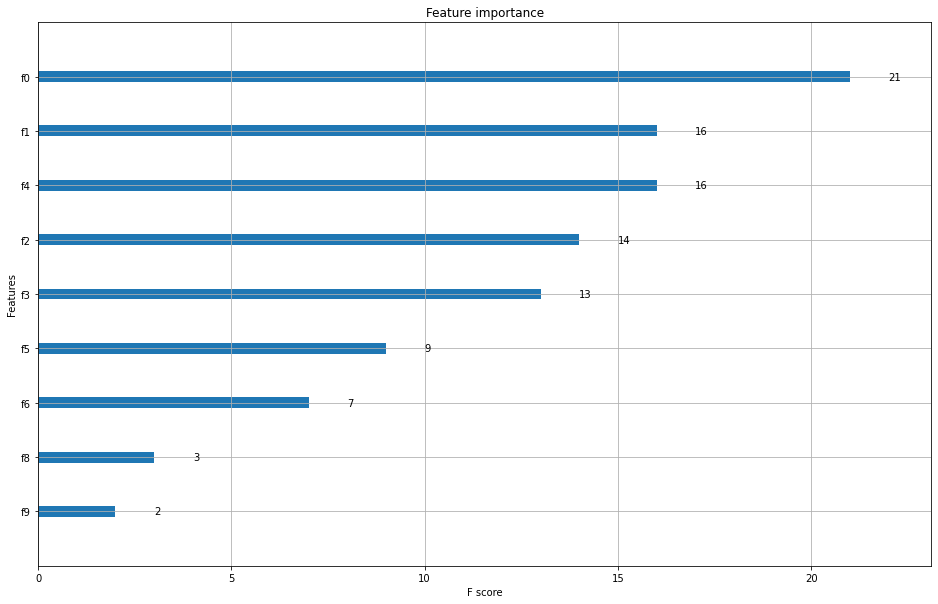

In [194]:
fig, ax = plt.subplots(figsize=(16,10))
xgb.plot_importance(model, ax=ax)
plt.show()

## Ensembling
We take a look at ensembling a couple of different models together

In [195]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor

ada_reg = AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=None),
                           n_estimators=50, random_state=seed)

In [196]:
from sklearn.ensemble import GradientBoostingRegressor

In [205]:
model1 = forest_reg

model2 = AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=None), 
                           n_estimators=50, random_state=seed)

model3 = GradientBoostingRegressor(max_depth=3, n_estimators=20, learning_rate=1.0, 
                                  random_state=seed)

model4 = r_xgb_reg

In [206]:
from sklearn.ensemble import VotingRegressor
ensemble = VotingRegressor([('rf', model1), 
                            ('ada', model2),
                            ('gb', model3),
                            ('xgb', model4)])

In [207]:
ensemble.fit(box_office_prepared, box_office_labels)

VotingRegressor(estimators=[('rf',
                             RandomForestRegressor(max_features=2,
                                                   n_estimators=300,
                                                   random_state=42)),
                            ('ada',
                             AdaBoostRegressor(base_estimator=DecisionTreeRegressor(),
                                               random_state=42)),
                            ('gb',
                             GradientBoostingRegressor(learning_rate=1.0,
                                                       n_estimators=20,
                                                       random_state=42)),
                            ('xgb',
                             XGBRegressor(base_score=0.5, booster='gbtree',
                                          colsample_bylevel=1,
                                          colsam...
                                          colsample_bytree=0.8, gamma=1.0,
             

In [208]:
mse=mean_squared_error(box_office_labels, ensemble.predict(box_office_prepared))
print(np.sqrt(mse))

30316725.83803318


##### Our RMSE is now down to  around 30k. Our ensemble looks quite good. 

In [209]:
ensemble_scores = cross_val_score(ensemble, box_office_prepared, box_office_labels, scoring="neg_mean_squared_error", cv=10)
ensemble_rmse_scores = np.sqrt(-ensemble_scores)
display_scores(ensemble_rmse_scores)

Scores: [70295168.0813337  71401999.43347089 94039885.33071518 68754783.07531644
 74297426.08969626 88358813.11099096 63522735.46507161 84060763.94432229
 77990455.54092285 68650578.46756862]
Mean: 76137260.85394089
Standard deviation: 9304310.384094767


However, cross validation shows that the model is overfitting quite a lot.

We save our ensemble model to joblib.

In [220]:
joblib.dump(ensemble, "ensemble_box_office.joblib", compress=8)

['ensemble_box_office.joblib']

# Choosing the final model and testing it
We choose the best estimator from the random search with top feature selecetion as our final model. We could (and probably should) do more work on the attributes and look for better results.

In [252]:
test_set = test.drop("id", axis=1)

In [253]:
test_set_fixed = fix_data(test_set)

In [255]:
test_set_fixed.isna().sum()

budget                           0
popularity                       0
runtime                         13
has_collection                   0
has_homepage                     0
no_of_genres                     0
original_language_is_english     0
no_of_production_companies       0
dtype: int64

In [256]:
test_set_fixed.head()

,budget,popularity,runtime,has_collection,has_homepage,no_of_genres,original_language_is_english,no_of_production_companies
0,0,3.851534,90.0,1,1,4,0,0
1,88000,3.559789,65.0,0,0,2,1,1
2,0,8.085194,100.0,0,0,2,1,3
3,6800000,8.596012,130.0,0,1,3,0,3
4,2000000,3.217680,92.0,0,0,2,1,0


In [262]:
test_set_prepared = full_pipeline.transform(test_set_fixed)

In [263]:
#pred = r_xgb_reg.predict(test_set_prepared)
pred = forest_reg.predict(test_set_prepared)

In [264]:
pred[:5]

array([17870467.5       ,  4114129.1       ,  5975828.79463094,
       37501229.59      ,  3907362.9       ])

# 7. Our solution and findings <a class="anchor" id="chapter7"> </a>
After looking at the data, cleaning it, and training and fine-tuning a model on it, we ended up with a RandomForestRegressor(max_features=1, n_estimators=248). 

The fact that we ended up with only 1 feature is a bit interesting, but this gave us the best RMSE score. However, we are not reaching a sufficiently good score, so we assume that our model is underfitting with our current model. 

In the kaggle submission we ended up with a score of 47258.01600, which is not the worst, but certainly not the best. 

# 8. Launching and Monitoring the System <a class="anchor" id="chapter8"><a/>
    
We are now finished training the model and ended up with a Random Forest Regressor. The next step is to find a deployment model that suits our needs. Our plan is to use this model in a web application that will query it through a REST API. Thus, we need to find a dedicated web service to host our ML model. 
    
After deploying we have to put in place a monitoring system to make sure our model performs as we expect it to over time. We assume that the data will evolve and that the model will require retraining. Our goal is to automate this process by regularly collecting fresh data, in addition to have a script that trains the model and fine-tunes the hyperparameters automatically. Based on this script we will have another script that makes a decision on whether or not to deploy the new model or keep the old one. 
    
It is a difficult task to automate everything, so we are prepared that our final system will require some human supervision and regular checks to make sure that its performance is satisfactory.
    